In [18]:
import pandas as pd
import numpy as np
from stable_baselines import A2C
from stable_baselines import PPO2
from stable_baselines import DDPG
from scipy.special import softmax
from stable_baselines.common.env_checker import check_env
import matplotlib.pyplot as plt
import gym
import time
import os


In [2]:
# hyperparameters
stock_dim = 30
action_dim = stock_dim + 1
feature_size = 6
observation_dim = feature_size * stock_dim + 2
initial_asset = 100000
cash_bias = 10000
softmax_regularization = 10000

In [3]:
# create environment
class tradeEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self,df,day=0,asset=initial_asset):

        self.day = day 
        self.df = df

        # initialize asset 
        self.asset = asset
        self.asset_memory = [asset]  

        # initialize account
        self.account = np.array([asset] + [0]*stock_dim)
        self.asset_proportion = np.array([1] + [0]*stock_dim) 
        self.account_memory = [self.account]

        # action space & observation space
        self.action_space = gym.spaces.Box(low=-1,high=1,shape=(action_dim,)) # grading method + softmax
        self.observation_space = gym.spaces.Box(low=-np.inf,high=np.inf,shape=(observation_dim,)) 

    def __get_obs(self,day):
        
        # state -> day's obs / data -> df.loc[day,:]
        data = self.df.loc[day,:]
        state = self.account.tolist() + [1] + data.adjcp.values.tolist() + data.macd.values.tolist() + data.rsi.values.tolist() + data.cci.values.tolist() + data.adx.values.tolist()
        # [  cash,stock1_on_hand,stock2_on_hand,...,stock30_on_hand,  1,stock1_price,stock2_price,...,stock30_price,  30*feature1 ,  30*feature2 , 30*feature3 , 30*feature4  ]   ->   dim: 182
        state = np.array(state).reshape(observation_dim,)
        return state

    def show_asset(self,format_string="r"):
        plt.plot(self.asset_memory,format_string)
        
    def show_stock_hold(self,stock_idx):
        mat = np.array(env.account_memory)
        mat = mat.T
        plt.plot(mat[stock_idx],"r")


    def step(self,actions):

        # calculate today's asset
        today_obs = self.__get_obs(self.day)
        today_prices = np.array(today_obs[action_dim:2*action_dim]) 
        self.asset = np.dot(self.account,today_prices) # todo 现金的价格标注为 1
        self.asset_memory.append(self.asset)

        # action asset proportion
        actions = actions * softmax_regularization  # aggressive trade strategy
        actions[0] += cash_bias                     # mild trade strategy 
        self.asset_proportion = softmax(actions)
        self.account = self.asset * self.asset_proportion / today_prices 
        self.account_memory.append(self.account)

        # calculate reward
        tomorrow_obs = self.__get_obs(self.day+1)
        tomorrow_prices = np.array(tomorrow_obs[action_dim:action_dim*2])
        tomorrow_asset = np.dot(self.account,tomorrow_prices)
        reward = tomorrow_asset - self.asset

        # step update
        self.day += 1
        done = self.day >= len(self.df.index.unique()) - 1

        # if done:
        #     plt.plot(self.asset_memory,"r")
        #     plt.savefig("result_fig.png")
        #     plt.close()


        return tomorrow_obs , reward , done , {}


    def reset(self):

        asset = initial_asset
        day = 0

        self.day = day 

        # initialize asset 
        self.asset = asset
        self.asset_memory = [asset]  

        # initialize account
        self.account = np.array([asset] + [0]*stock_dim)
        self.asset_proportion = np.array([1] + [0]*stock_dim)

        today_obs = self.__get_obs(0)

        return today_obs


    def render(self, mode="human"):

        today_obs = self.__get_obs(self.day)

        return today_obs







In [4]:
def train_A2C(model_name,train_env,time_steps=70000):
    model = A2C("MlpPolicy",env=train_env,verbose=1)
    model.learn(time_steps) 
    model.save("model/"+model_name)
    return model

def train_PPO2(model_name,train_env,time_steps=70000,batch_size=4):
    model = PPO2("MlpPolicy",env=train_env,nminibatches=batch_size,verbose=1)
    model.learn(time_steps) 
    model.save("model/"+model_name)
    return model

def train_DDPG(model_name,train_env,time_steps=70000):
    model = DDPG("MlpPolicy",env=train_env,verbose=1)
    model.learn(time_steps)
    model.save("model/"+model_name)
    return model

In [5]:
# load data set
data_df = pd.read_csv('dataSet/stock_data/done_data.csv')
train_set = data_df[(data_df['datadate'] < 20151001)]
test_set = data_df[(data_df['datadate'] > 20151001) & (data_df['datadate'] < 20190707)]
nightmare_set = data_df[(data_df['datadate'] > 20190707)]

# preprocess data set
train_set = train_set.sort_values(['datadate','tic'],ignore_index=True) 
train_set.index = train_set.datadate.factorize()[0]
env = tradeEnv(train_set)

test_set = test_set.sort_values(['datadate','tic'],ignore_index=True) 
test_set.index = test_set.datadate.factorize()[0]
t_env = tradeEnv(test_set)


# catastrophy happened in 2020
nightmare_set = nightmare_set.sort_values(['datadate','tic'],ignore_index=True) 
nightmare_set.index = nightmare_set.datadate.factorize()[0]
hell_env = tradeEnv(nightmare_set)

# check_env(env)


In [ ]:
# train a model

model = train_DDPG("my_DDPG",env,20000)

obs = env.reset() 


for i in range(len(train_set.index.unique())-1):
    act , _ = model.predict(obs)
    obs , reward , done , info = env.step(act) 

env.show_asset()
print(env.asset)


In [6]:
def test_model(model,target_set):
    
    target_env = tradeEnv(target_set)
    obs = target_env.reset()

    for i in range(len(target_set.index.unique())-1):
        act , _ = model.predict(obs)
        obs , reward , done , info = target_env.step(act)

    target_env.show_asset("r")
    return target_env.asset

def random_strategy(target_set):

    target_env = tradeEnv(target_set)
    obs = target_env.reset()

    for i in range(len(target_set.index.unique())-1):
        act = np.random.randn(action_dim)
        obs , reward , done , info = target_env.step(act) 

    target_env.show_asset("b")
    return target_env.asset


    

In [ ]:
# test model
print("DRL-strategy:",test_model(model,test_set))
print("Random-strategy:",random_strategy(test_set))

In [7]:
# create super-agent
def create_super_agent(training_set,testing_set):

    training_env = tradeEnv(training_set)
    testing_env  = tradeEnv(testing_set) 

    A2C_step = 10
    DDPG_step = 10
    PPO2_step = 10

    model_dict = {}

    for i in range(A2C_step):
        time_steps = (i+1) * 100000
        model_name = "a2c_agent_timestep="+ str(time_steps)
        model = train_A2C(model_name,train_env=training_env,time_steps=time_steps)
        test_asset = test_model(model,testing_set)
        model_dict[model_name] = test_asset

    for i in range(DDPG_step):
        time_steps = (i+1) * 50000
        model_name = "ddpg_agent_timestep=" + str(time_steps)
        model = train_DDPG(model_name,train_env=training_env,time_steps=time_steps)
        test_asset = test_model(model,test_set)
        model_dict[model_name] = test_asset

    for i in range(PPO2_step):
        time_steps = (i+1) * 50000
        model_name = "ppo2_agent_timestep=" + str(time_steps)

        name1 = model_name+"_batch=8"
        model = train_PPO2(name1,train_env=training_env,time_steps=time_steps,batch_size=8)
        test_asset = test_model(model,test_set) 
        model_dict[name1] = test_asset
        
        name2 = model_name+"_batch=32"
        model = train_PPO2(name2,train_env=training_env,time_steps=time_steps,batch_size=32)
        test_asset = test_model(model,test_set)
        model_dict[name2] = test_asset

    print(model_dict)





In [22]:
# compare all the models
def compare_all_models(path,testing_set):

    model_dict = {}
    model_names = os.listdir(path)

    for model_name in model_names:

        if os.path.isdir(path + "/" +model_name):
            continue

        if model_name[0] == 'a':
            model = A2C.load(path+"/"+model_name)
        elif model_name[0] == 'd':
            model = DDPG.load(path+"/"+model_name)
        else:
            model = PPO2.load(path+"/"+model_name) 

        m_asset = test_model(model,testing_set)

        model_dict[model_name] = m_asset

    return model_dict
        



In [ ]:
# victim cache

#model = PPO2.load("temp_model")

t_dict = compare_all_models("model",test_set)

a2c_list = []
ddpg_list = [] 
ppo2_list = []

a2c_val = []
ddpg_val = []
ppo2_val = []

for key in t_dict:
    if key[0] == "a":
        a2c_list.append(key)
        a2c_val.append(t_dict[key])
    elif key[0] == "d":
        ddpg_list.append(key)
        ddpg_val.append(t_dict[key])
    else:
        ppo2_list.append(key)
        ppo2_val.append(t_dict[key])


# plt.plot(env.asset_memory,"r")
# plt.savefig("test_fig.png")
# plt.close()
#create_super_agent(train_set,test_set)

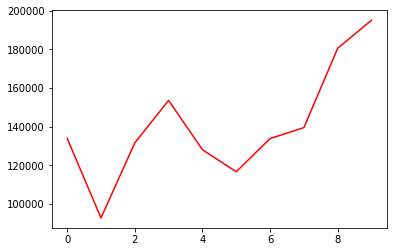

In [30]:
# terminal 

plt.plot(ddpg_val,"r")
# plt.plot()
